## Predicting damage with Logistic Regression

In [1]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.2 MB/s 


In [2]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def wrangle(db_path):
    # # Connect to database
    # conn = sqlite3.connect(db_path)

    # # Construct query
    # query = """
    #     SELECT distinct(i.building_id) AS b_id,
    #        s.*,
    #        d.damage_grade
    #     FROM id_map AS i
    #     JOIN building_structure AS s ON i.building_id = s.building_id
    #     JOIN building_damage AS d ON i.building_id = d.building_id
    #     WHERE district_id = 4
    # """

    df = pd.read_excel(db_path)


    # Read query results into DataFrame
    # df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Create Binary Target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicollinearity columns
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high-cardinality column
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    
    return df

In [4]:
df = wrangle("/content/data_1.xlsx")
df.head()

,Unnamed: 0,b_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
0,1,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
1,2,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
2,3,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
3,4,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
4,5,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [ ]:
# drop_cols = []
# for col in df.columns:
#     if "post_eq" in col:
#         drop_cols.append(col)

# LIST COMPREHENTSION
# drop_cols = [col for col in df.columns if "post_eq" in col]

# drop_cols

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70836 entries, 0 to 70835
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              70836 non-null  int64 
 1   b_id                    70836 non-null  int64 
 2   age_building            70836 non-null  int64 
 3   plinth_area_sq_ft       70836 non-null  int64 
 4   height_ft_pre_eq        70836 non-null  int64 
 5   land_surface_condition  70836 non-null  object
 6   foundation_type         70836 non-null  object
 7   roof_type               70836 non-null  object
 8   ground_floor_type       70836 non-null  object
 9   other_floor_type        70836 non-null  object
 10  position                70836 non-null  object
 11  plan_configuration      70836 non-null  object
 12  superstructure          70836 non-null  object
 13  severe_damage           70836 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 7.6+ MB
None


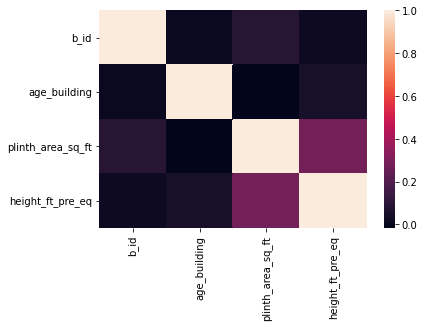

In [9]:
df.drop(columns="Unnamed: 0", inplace=True)
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()

# Plot heatmap of `correlation`
sns.heatmap(correlation);

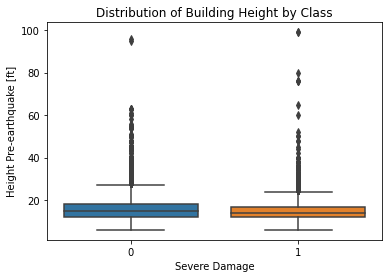

In [10]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel('Height Pre-earthquake [ft]')
plt.title("Distribution of Building Height by Class");

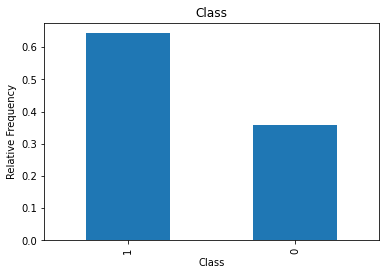

In [11]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class"
)

In [12]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


In [13]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


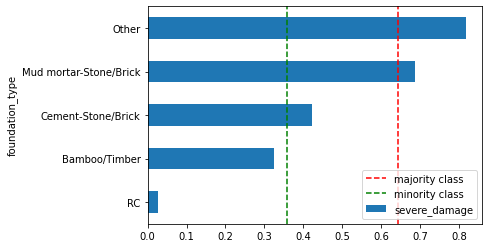

In [14]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label = "minority class"
)
plt.legend(loc="lower right");

In [15]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

In [16]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 12)
y_train shape: (56668,)
X_test shape: (14168, 12)
y_test shape: (14168,)


In [18]:
y_train.value_counts(normalize=True).max()

0.6410319757182183

In [19]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


In [20]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [21]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.65
Test Accuracy: 0.65


In [22]:
model.predict(X_train)[:5]

array([0, 1, 1, 1, 1])

In [23]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.53432817 0.46567183]
 [0.37298141 0.62701859]
 [0.27687253 0.72312747]
 [0.35455978 0.64544022]
 [0.33607894 0.66392106]]


In [24]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [25]:
odds_ratios =  pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

plinth_area_sq_ft       0.999135
ground_floor_type_RC    0.999907
roof_type_RCC/RB/RBC    0.999925
height_ft_pre_eq        0.999928
foundation_type_RC      0.999929
dtype: float64

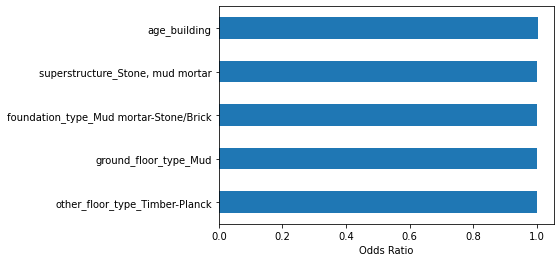

In [26]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

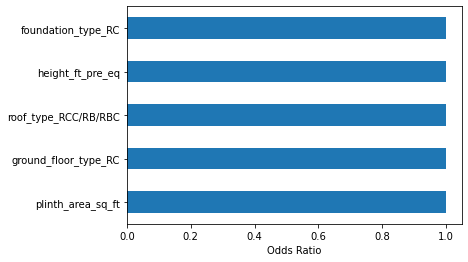

In [27]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");